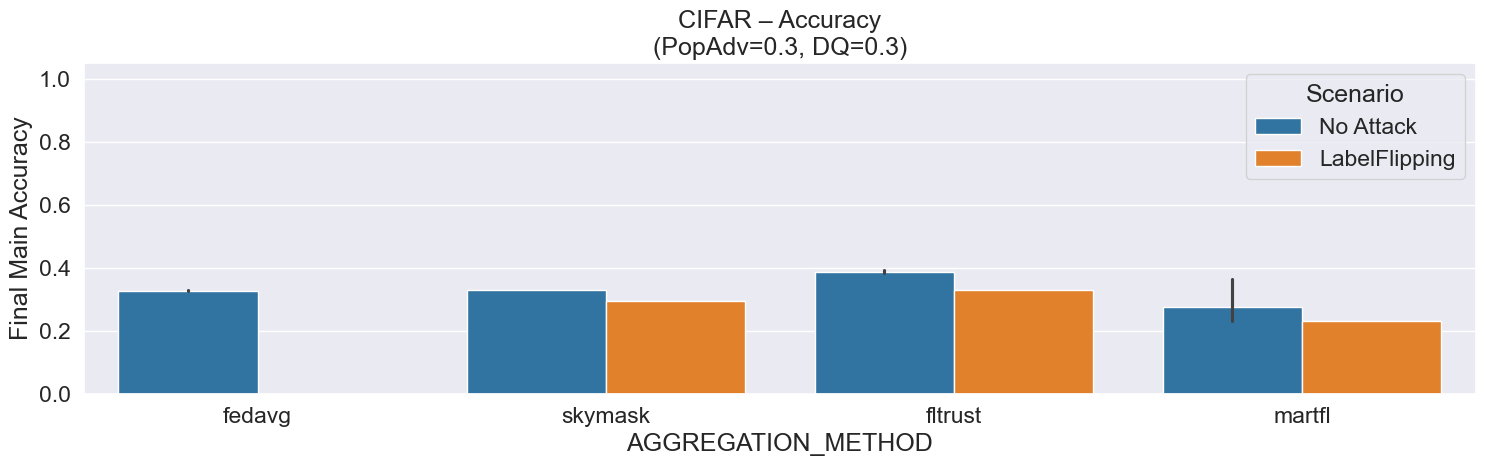

saved results\paper_figures\label_flipping_robustness_csv\acc_CIFAR_LabelFlipping.pdf


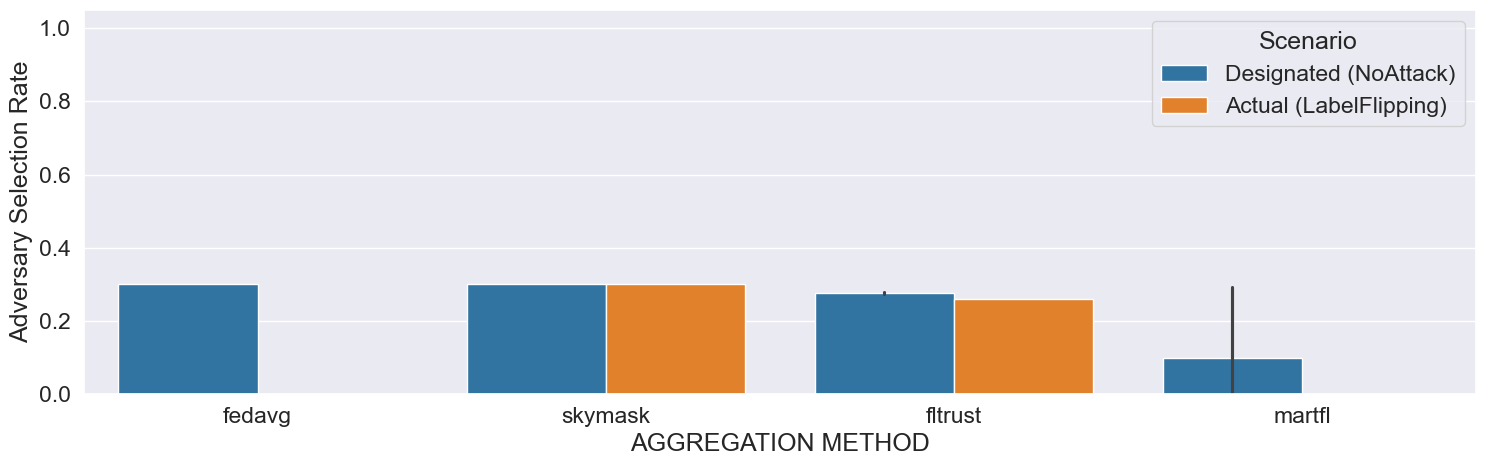

saved results\paper_figures\label_flipping_robustness_csv\sel_CIFAR_LabelFlipping.pdf


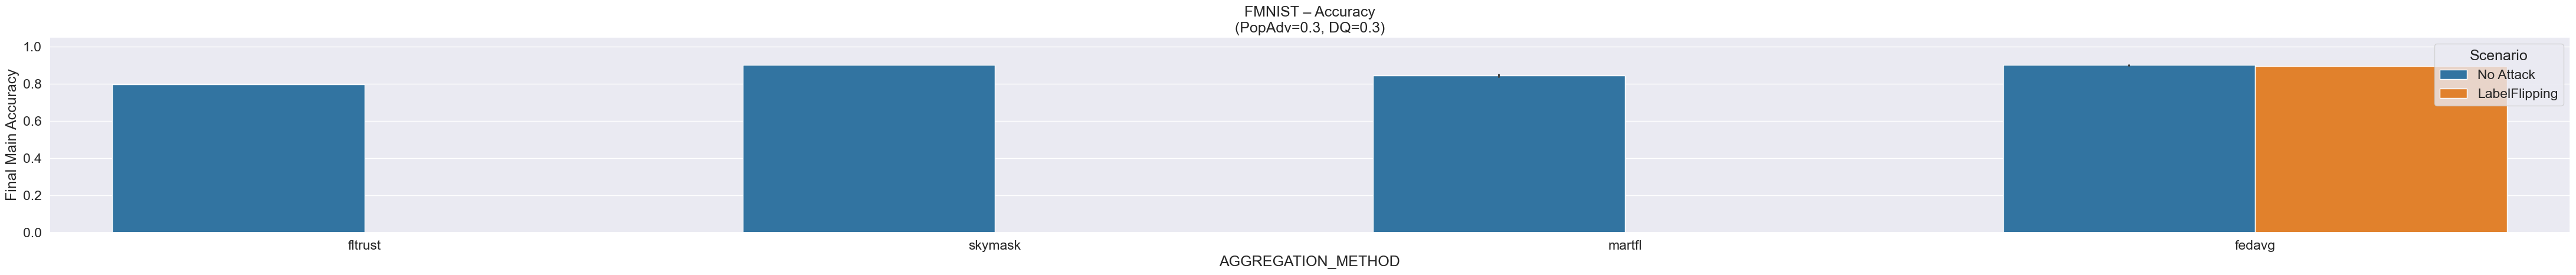

saved results\paper_figures\label_flipping_robustness_csv\acc_FMNIST_LabelFlipping.pdf


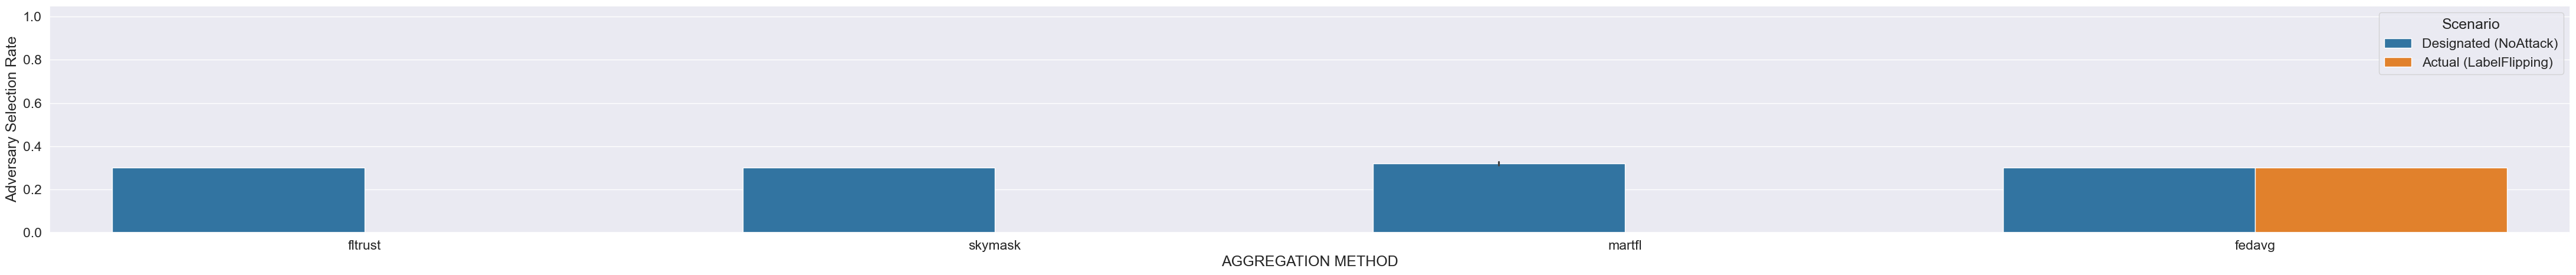

saved results\paper_figures\label_flipping_robustness_csv\sel_FMNIST_LabelFlipping.pdf


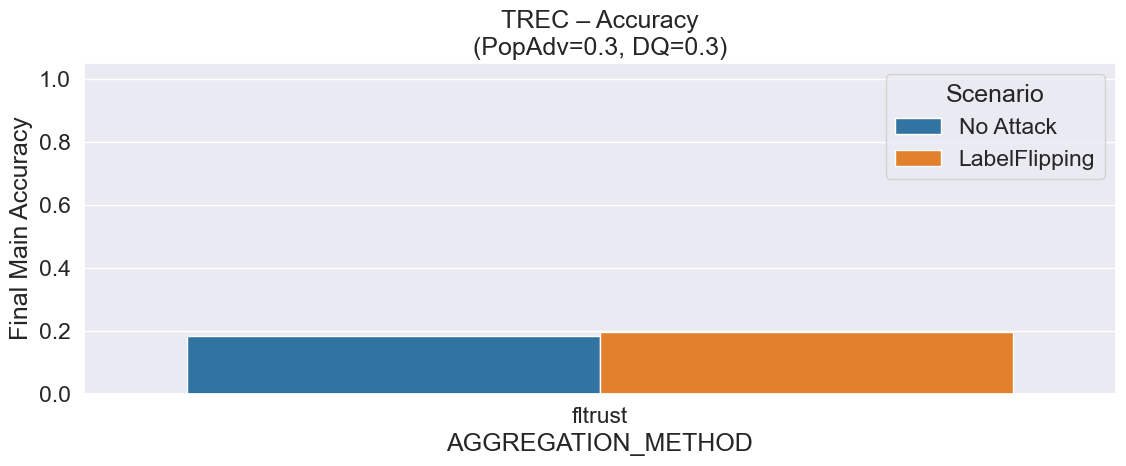

saved results\paper_figures\label_flipping_robustness_csv\acc_TREC_LabelFlipping.pdf


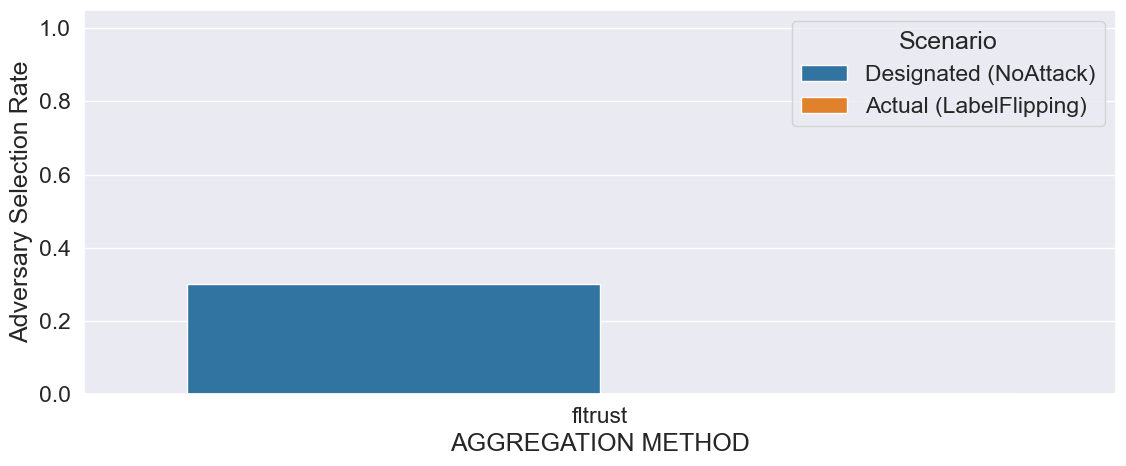

saved results\paper_figures\label_flipping_robustness_csv\sel_TREC_LabelFlipping.pdf


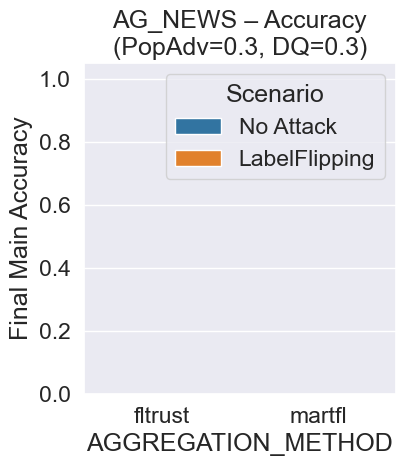

saved results\paper_figures\label_flipping_robustness_csv\acc_AG_NEWS_LabelFlipping.pdf


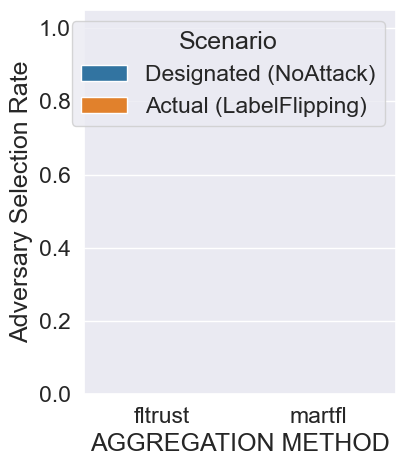

saved results\paper_figures\label_flipping_robustness_csv\sel_AG_NEWS_LabelFlipping.pdf


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# CONFIG – tweak as needed or turn them into CLI args
# ---------------------------------------------------------------------
CSV_PATH              = Path("../result_new/summary_avg.csv")   # your upload
FIXED_POP_ADV_RATE    = 0.3       # pair on this population rate
DISCOVERY_QUALITY     = 0.3
BUYER_MODE            = "unbiased"
SAVE_DIR              = Path("./results/paper_figures/label_flipping_robustness_csv")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
# ---------------------------------------------------------------------

ATTACK_LABELS = {
    "label_flip":  "LabelFlipping",
    "backdoor":    "Backdoor",
    None:          "NoAttack",
    "":            "NoAttack"
}

def load_and_tag(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    # Tag rows with an EFFECTIVE_ATTACK column
    df["EFFECTIVE_ATTACK"] = (
        df["attack_objective"]
        .map(lambda x: ATTACK_LABELS.get(str(x).strip().lower(), "UnknownAttack"))
    )

    # Derive No‑Attack rows when adv rate is 0
    df.loc[df["ADV_RATE"].eq(0), "EFFECTIVE_ATTACK"] = "NoAttack"

    # Keep separate columns for clarity
    df = df.rename(columns={"ADV_RATE": "ADV_RATE_effective"})
    df["ADV_RATE_population"] = df["ADV_RATE_effective"].where(
        df["EFFECTIVE_ATTACK"] != "NoAttack", FIXED_POP_ADV_RATE
    )
    return df

def make_barplots(df: pd.DataFrame, dataset: str, attack: str) -> None:
    """
    Produces two bar charts (accuracy & selection rate) for one dataset + attack.
    Saves them as PDF in SAVE_DIR and shows them inline.
    """
    base = df.query(
        "DATASET == @dataset and "
        "discovery_quality == @DISCOVERY_QUALITY and "
        "buyer_data_mode == @BUYER_MODE and "
        "ADV_RATE_population == @FIXED_POP_ADV_RATE"
    )

    df_attack  = base.query("EFFECTIVE_ATTACK == @attack").copy()
    df_no_atk  = base.query("EFFECTIVE_ATTACK == 'NoAttack'").copy()

    if df_attack.empty or df_no_atk.empty:
        print(f"[skip] {dataset}: missing rows for attack={attack}")
        return

    paired = pd.merge(
        df_attack[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   "AVG_ADVERSARY_SELECTION_RATE"]],
        df_no_atk[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}"]],
        on="AGGREGATION_METHOD",
        suffixes=("_attack", "_baseline")
    )

    # ---------- Accuracy ----------
    acc_long = paired.melt(id_vars="AGGREGATION_METHOD",
                           value_vars=["FINAL_MAIN_ACC_baseline",
                                       "FINAL_MAIN_ACC_attack"],
                           var_name="Scenario", value_name="Accuracy")
    acc_long["Scenario"] = acc_long["Scenario"].map({
        "FINAL_MAIN_ACC_baseline": "No Attack",
        "FINAL_MAIN_ACC_attack":   attack
    })

    plt.figure(figsize=(2 + 1.2*len(paired), 5))
    sns.barplot(data=acc_long,
                x="AGGREGATION_METHOD", y="Accuracy", hue="Scenario",
                order=paired["AGGREGATION_METHOD"])
    plt.ylim(0, 1.05); plt.ylabel("Final Main Accuracy")
    plt.title(f"{dataset} – Accuracy\n(PopAdv={FIXED_POP_ADV_RATE}, DQ={DISCOVERY_QUALITY})")
    plt.tight_layout()
    fname = SAVE_DIR / f"acc_{dataset}_{attack}.pdf"
    plt.savefig(fname); plt.show()
    print("saved", fname)

    # ---------- Selection rate ----------
    sel_long = paired.melt(id_vars="AGGREGATION_METHOD",
                           value_vars=[f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}",
                                       "AVG_ADVERSARY_SELECTION_RATE"],
                           var_name="Scenario", value_name="SelRate")
    sel_long["Scenario"] = sel_long["Scenario"].map({
        f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}": "Designated (NoAttack)",
        "AVG_ADVERSARY_SELECTION_RATE": f"Actual ({attack})"
    })

    plt.figure(figsize=(2 + 1.2*len(paired), 5))
    sns.set_context("notebook", font_scale=1.5)
    sns.barplot(data=sel_long,
                x="AGGREGATION_METHOD", y="SelRate", hue="Scenario",
                order=paired["AGGREGATION_METHOD"])
    plt.xlabel("AGGREGATION METHOD", fontsize=18)

    plt.ylim(0, 1.05); plt.ylabel("Adversary Selection Rate")
    # plt.title(f"{dataset} – Selection Rate\n(PopAdv={FIXED_POP_ADV_RATE}, DQ={DISCOVERY_QUALITY})")
    plt.tight_layout()
    fname = SAVE_DIR / f"sel_{dataset}_{attack}.pdf"
    plt.savefig(fname); plt.show()
    print("saved", fname)

# ---------------------------------------------------------------------
if __name__ == "__main__":
    df = load_and_tag(CSV_PATH)

    for ds in df["DATASET"].unique():
        for atk in ["LabelFlipping"]:     # add "Backdoor" if needed
            make_barplots(df, ds, atk)


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# CONFIG – tweak as needed or turn them into CLI args
# ---------------------------------------------------------------------
CSV_PATH              = Path("../result_new/summary_avg.csv")   # your upload
FIXED_POP_ADV_RATE    = 0.3       # pair on this population rate
DISCOVERY_QUALITY     = 0.3
BUYER_MODE            = "unbiased"
SAVE_DIR              = Path("./results/paper_figures/label_flipping_robustness_csv")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
# ---------------------------------------------------------------------

ATTACK_LABELS = {
    "label_flip":  "LabelFlipping",
    "backdoor":    "Backdoor",
    None:          "NoAttack",
    "":            "NoAttack"
}

def load_and_tag(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    # Tag rows with an EFFECTIVE_ATTACK column
    df["EFFECTIVE_ATTACK"] = (
        df["attack_objective"]
        .map(lambda x: ATTACK_LABELS.get(str(x).strip().lower(), "UnknownAttack"))
    )

    # Derive No‑Attack rows when adv rate is 0
    df.loc[df["ADV_RATE"].eq(0), "EFFECTIVE_ATTACK"] = "NoAttack"

    # Keep separate columns for clarity
    df = df.rename(columns={"ADV_RATE": "ADV_RATE_effective"})
    df["ADV_RATE_population"] = df["ADV_RATE_effective"].where(
        df["EFFECTIVE_ATTACK"] != "NoAttack", FIXED_POP_ADV_RATE
    )
    return df

def make_barplots(df: pd.DataFrame, dataset: str, attack: str) -> None:
    """
    Produces two bar charts (accuracy & selection rate) for one dataset + attack.
    Saves them as PDF in SAVE_DIR and shows them inline.
    """
    base = df.query(
        "DATASET == @dataset and "
        "discovery_quality == @DISCOVERY_QUALITY and "
        "buyer_data_mode == @BUYER_MODE and "
        "ADV_RATE_population == @FIXED_POP_ADV_RATE"
    )

    df_attack  = base.query("EFFECTIVE_ATTACK == @attack").copy()
    df_no_atk  = base.query("EFFECTIVE_ATTACK == 'NoAttack'").copy()

    if df_attack.empty or df_no_atk.empty:
        print(f"[skip] {dataset}: missing rows for attack={attack}")
        return
    print(df_attack[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   "AVG_ADVERSARY_SELECTION_RATE"]])
    print(df_no_atk[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}"]])

    paired = pd.merge(
        df_attack[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   "AVG_ADVERSARY_SELECTION_RATE"]],
        df_no_atk[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}"]],
        on="AGGREGATION_METHOD",
        suffixes=("_attack", "_baseline")
    )

    # ---------- Accuracy ----------
    acc_long = paired.melt(id_vars="AGGREGATION_METHOD",
                           value_vars=["FINAL_MAIN_ACC_baseline",
                                       "FINAL_MAIN_ACC_attack"],
                           var_name="Scenario", value_name="Accuracy")
    acc_long["Scenario"] = acc_long["Scenario"].map({
        "FINAL_MAIN_ACC_baseline": "No Attack",
        "FINAL_MAIN_ACC_attack":   attack
    })

    plt.figure(figsize=(2 + 1.2*len(paired), 5))
    sns.barplot(data=acc_long,
                x="AGGREGATION_METHOD", y="Accuracy", hue="Scenario",
                order=paired["AGGREGATION_METHOD"])
    plt.ylim(0, 1.05); plt.ylabel("Final Main Accuracy")
    plt.title(f"{dataset} – Accuracy\n(PopAdv={FIXED_POP_ADV_RATE}, DQ={DISCOVERY_QUALITY})")
    plt.tight_layout()
    fname = SAVE_DIR / f"acc_{dataset}_{attack}.pdf"
    plt.savefig(fname); plt.show()
    print("saved", fname)

    # ---------- Selection rate ----------
    sel_long = paired.melt(id_vars="AGGREGATION_METHOD",
                           value_vars=[f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}",
                                       "AVG_ADVERSARY_SELECTION_RATE"],
                           var_name="Scenario", value_name="SelRate")
    sel_long["Scenario"] = sel_long["Scenario"].map({
        f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}": "Designated (NoAttack)",
        "AVG_ADVERSARY_SELECTION_RATE": f"Actual ({attack})"
    })

    plt.figure(figsize=(2 + 1.2*len(paired), 5))
    sns.barplot(data=sel_long,
                x="AGGREGATION_METHOD", y="SelRate", hue="Scenario",
                order=paired["AGGREGATION_METHOD"])
    plt.ylim(0, 1.05); plt.ylabel("Adversary Selection Rate")
    plt.title(f"{dataset} – Selection Rate\n(PopAdv={FIXED_POP_ADV_RATE}, DQ={DISCOVERY_QUALITY})")
    plt.tight_layout()
    fname = SAVE_DIR / f"sel_{dataset}_{attack}.pdf"
    plt.savefig(fname); plt.show()
    print("saved", fname)
    plt.show()
    


    AGGREGATION_METHOD  FINAL_MAIN_ACC  AVG_ADVERSARY_SELECTION_RATE
76              fedavg        0.295733                      0.300000
81             fltrust        0.315467                      0.006000
83             skymask        0.342667                      0.300000
87              martfl        0.372350                      0.462187
101            skymask        0.299200                      0.300000
105             martfl        0.231167                      0.001667
108            fltrust        0.347267                      0.275749
   AGGREGATION_METHOD  FINAL_MAIN_ACC  NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
0              fedavg        0.330433                          0.300000
31            skymask        0.330000                          0.300000
32             martfl        0.231567                          0.001667
33             martfl        0.231567                          0.001667
35            fltrust             NaN                               NaN
37             f

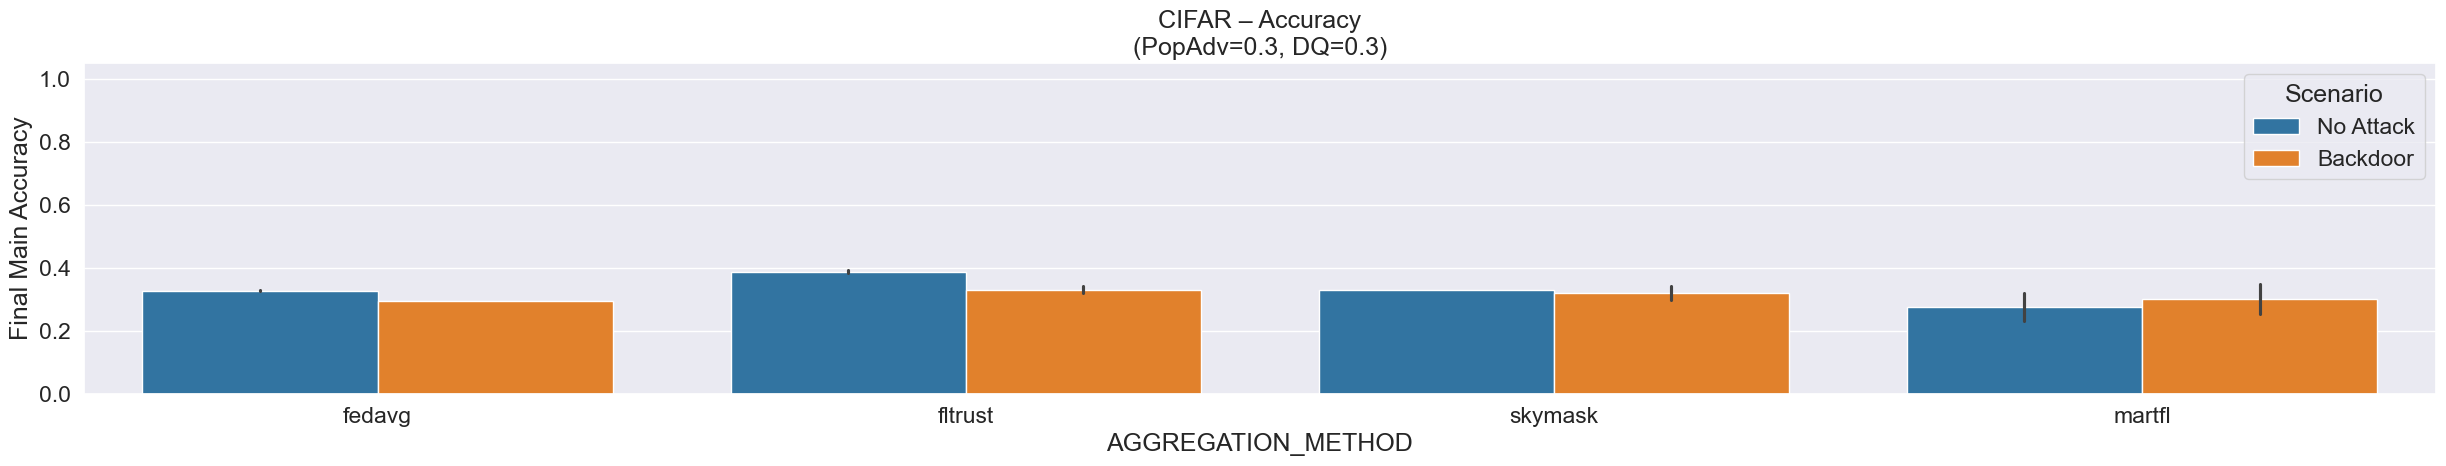

saved results\paper_figures\label_flipping_robustness_csv\acc_CIFAR_Backdoor.pdf


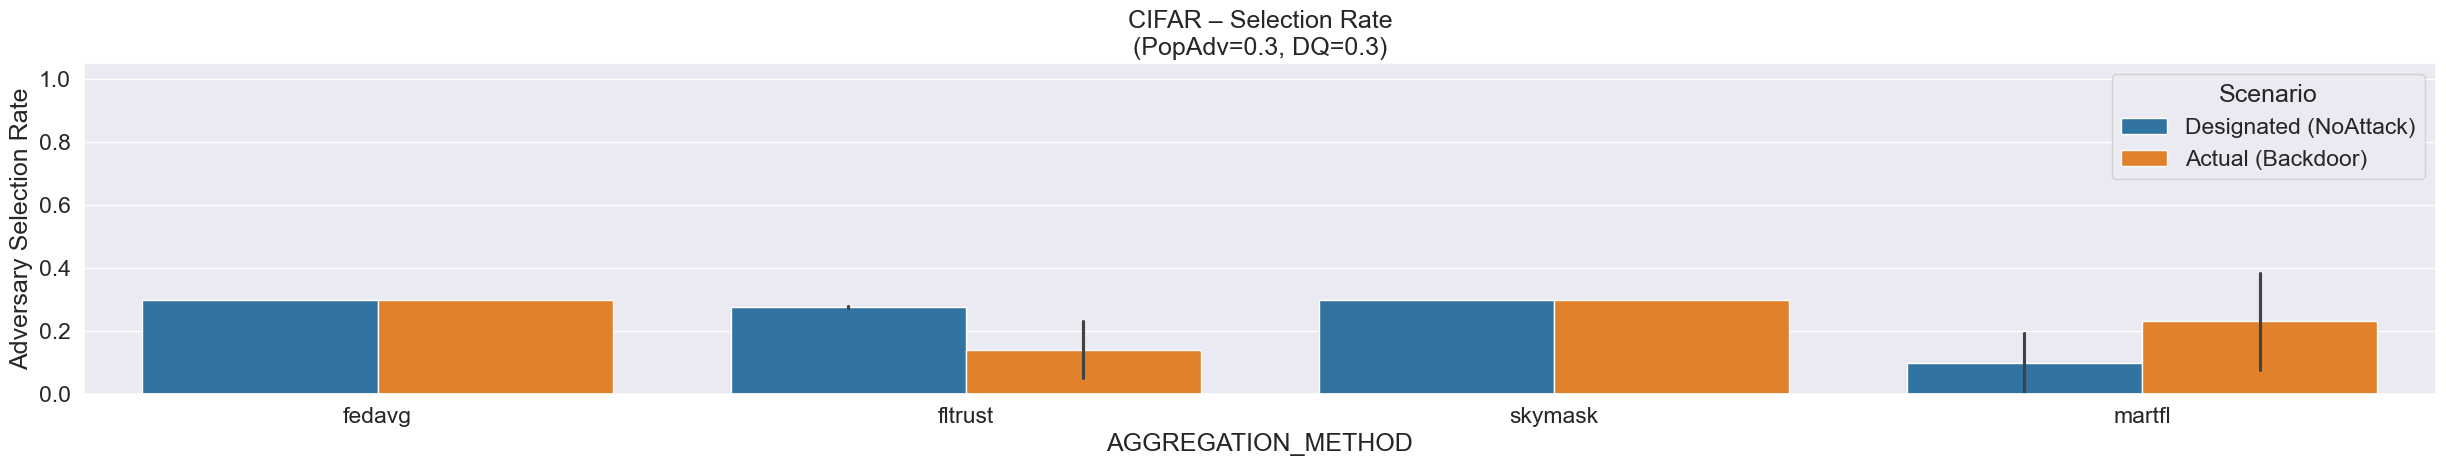

saved results\paper_figures\label_flipping_robustness_csv\sel_CIFAR_Backdoor.pdf
    AGGREGATION_METHOD  FINAL_MAIN_ACC  AVG_ADVERSARY_SELECTION_RATE
77             skymask        0.890000                      0.300000
84              martfl        0.895650                      0.111482
86              martfl        0.896833                      0.138831
97             fltrust        0.793667                      0.295046
99              fedavg             NaN                           NaN
100            skymask        0.899267                      0.300000
110            fltrust             NaN                           NaN
   AGGREGATION_METHOD  FINAL_MAIN_ACC  NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
1              fedavg        0.900350                          0.300000
34            skymask        0.900000                          0.300000
36             fedavg        0.899467                          0.300000
38            fltrust        0.795733                          0.300000
40     

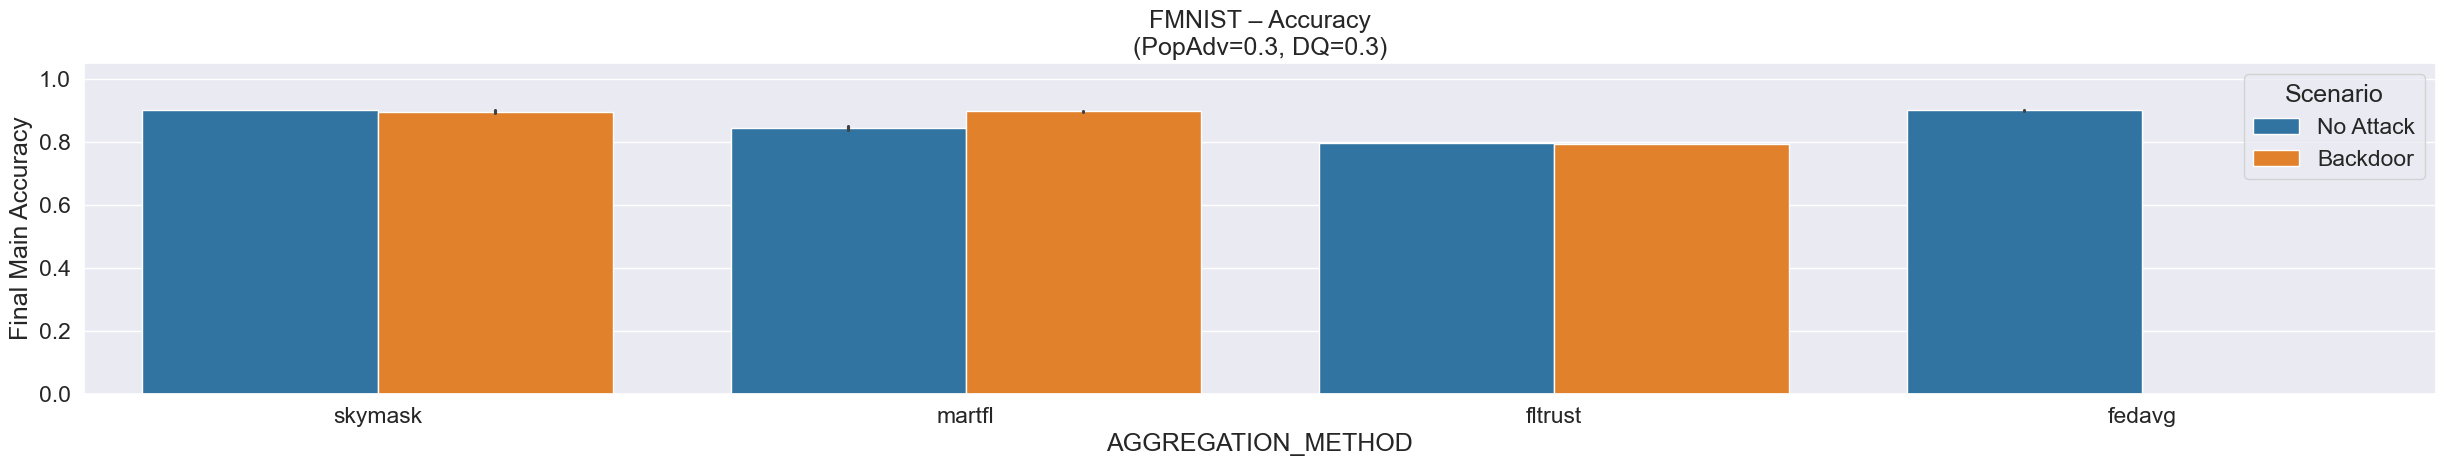

saved results\paper_figures\label_flipping_robustness_csv\acc_FMNIST_Backdoor.pdf


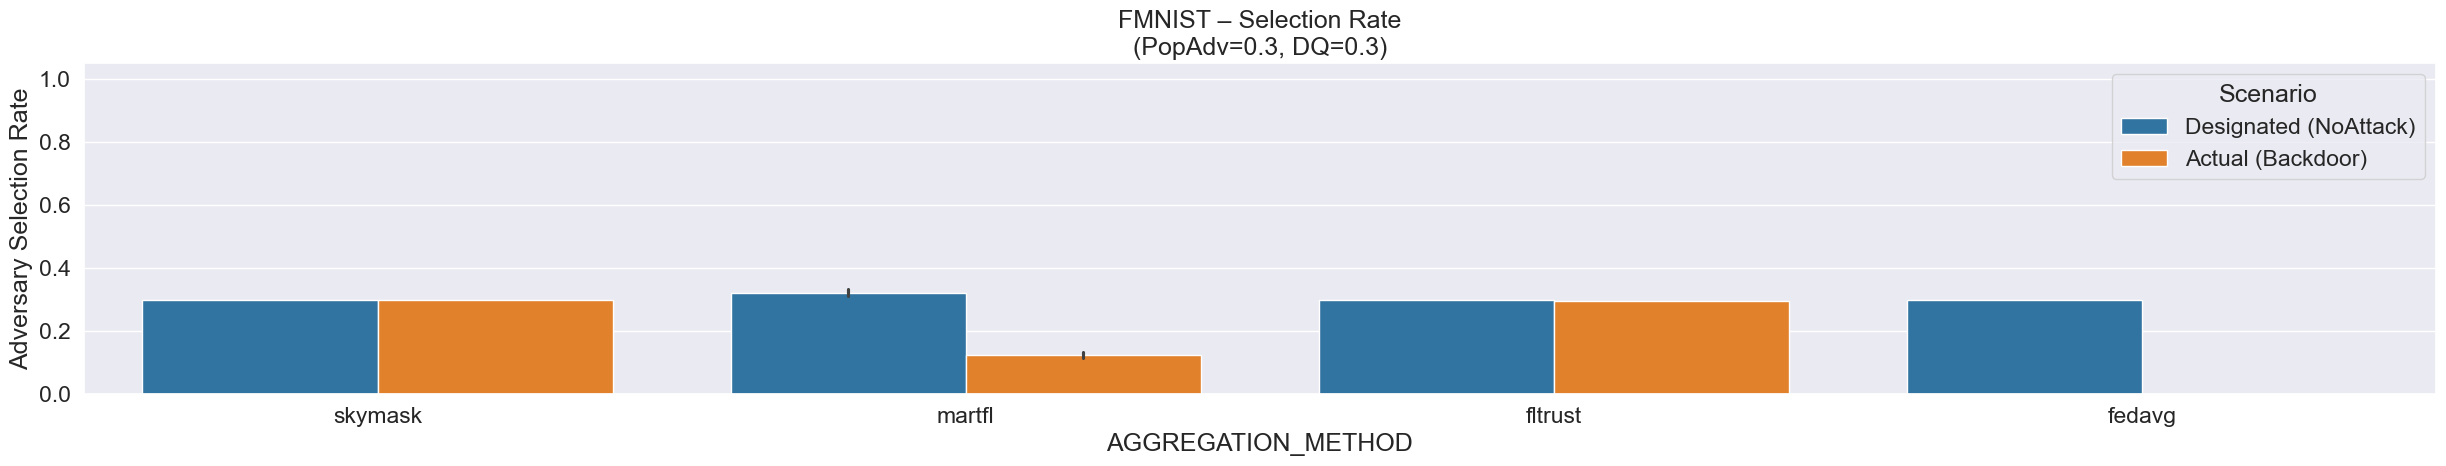

saved results\paper_figures\label_flipping_robustness_csv\sel_FMNIST_Backdoor.pdf
    AGGREGATION_METHOD  FINAL_MAIN_ACC  AVG_ADVERSARY_SELECTION_RATE
68              martfl           0.688                      0.240161
70              martfl             NaN                           NaN
72             skymask             NaN                           NaN
73             fltrust           0.198                      0.243000
75             fltrust           0.198                      0.243000
79              martfl             NaN                           NaN
82              martfl           0.362                      0.239571
85              martfl           0.462                      0.235762
90             fltrust             NaN                           NaN
92              martfl             NaN                           NaN
102             martfl           0.346                      0.239988
103             fedavg             NaN                           NaN
107            fltrus

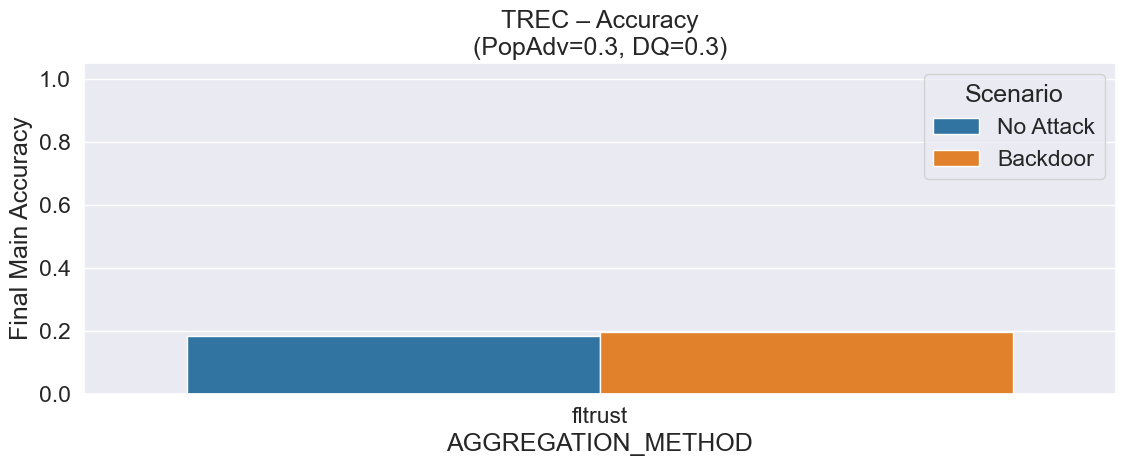

saved results\paper_figures\label_flipping_robustness_csv\acc_TREC_Backdoor.pdf


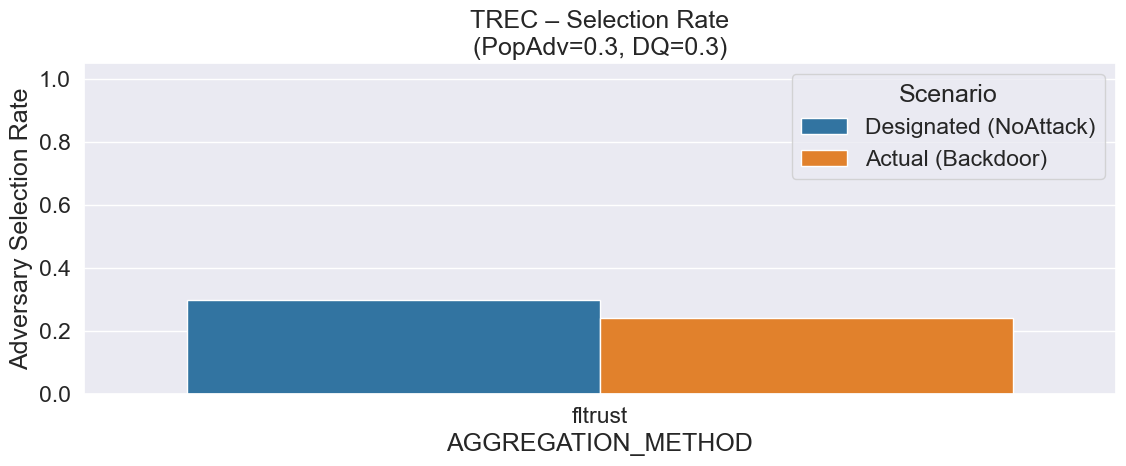

saved results\paper_figures\label_flipping_robustness_csv\sel_TREC_Backdoor.pdf
    AGGREGATION_METHOD  FINAL_MAIN_ACC  AVG_ADVERSARY_SELECTION_RATE
78              martfl             NaN                           NaN
89             fltrust             NaN                           NaN
91              martfl             NaN                           NaN
96             skymask             NaN                           NaN
104             martfl             NaN                           NaN
106             fedavg             NaN                           NaN
   AGGREGATION_METHOD  FINAL_MAIN_ACC  NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
55            fltrust             NaN                               NaN
64             martfl             NaN                               NaN


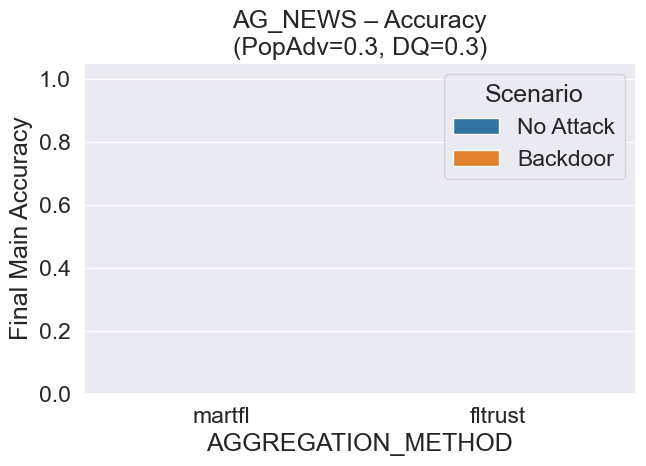

saved results\paper_figures\label_flipping_robustness_csv\acc_AG_NEWS_Backdoor.pdf


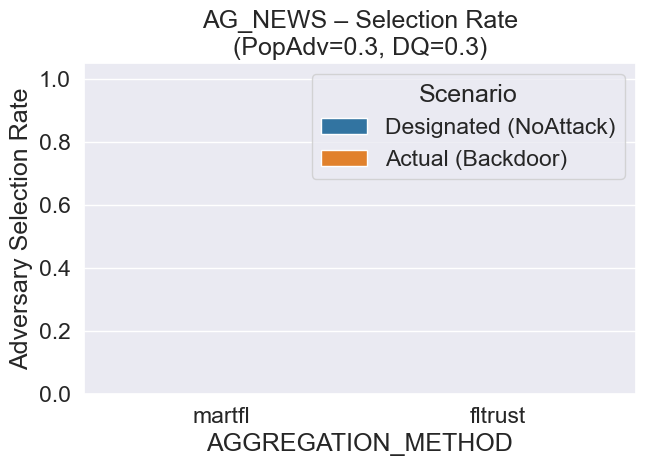

saved results\paper_figures\label_flipping_robustness_csv\sel_AG_NEWS_Backdoor.pdf


In [10]:
for ds in df["DATASET"].unique():
    for atk in ["Backdoor"]:     # add "Backdoor" if needed
        make_barplots(df, ds, atk)

In [78]:
import numpy as np
import pandas as pd
# import seaborn as sns # Not needed for table generation
# import matplotlib.pyplot as plt # Not needed for table generation
from pathlib import Path
# import io # Not strictly needed if writing directly

# ---------------------------------------------------------------------
# CONFIG – tweak as needed or turn them into CLI args
# ---------------------------------------------------------------------
CSV_PATH              = Path("../result_new/summary_avg.csv")   # your upload
FIXED_POP_ADV_RATE    = 0.3       # pair on this population rate
DISCOVERY_QUALITY     = 0.3
BUYER_MODE            = "unbiased"
SAVE_DIR              = Path("./results/paper_tables/selection_rates") # New save directory for tables
SAVE_DIR.mkdir(parents=True, exist_ok=True)
# ---------------------------------------------------------------------

ATTACK_LABELS = {
    "label_flip":  "LabelFlipping",
    "backdoor":    "Backdoor",
    None:          "NoAttack",
    "":            "NoAttack"
}

NAN_PLACEHOLDER = "--" # Or "N/A" or ""
# ---------------------------------------------------------------------

def load_and_tag(csv_path: Path) -> pd.DataFrame:
    """
    Loads the CSV, tags rows, derives ADV_RATE_population,
    and fills NaN values in relevant selection rate columns with a placeholder.
    """
    df = pd.read_csv(csv_path)

    # Tag rows with an EFFECTIVE_ATTACK column
    df["EFFECTIVE_ATTACK"] = (
        df["attack_objective"]
        .map(lambda x: ATTACK_LABELS.get(str(x).strip().lower(), "UnknownAttack"))
    )

    # Derive No‑Attack rows when adv rate is 0
    df.loc[df["ADV_RATE"].eq(0), "EFFECTIVE_ATTACK"] = "NoAttack"

    # Keep separate columns for clarity
    df = df.rename(columns={"ADV_RATE": "ADV_RATE_effective"})
    df["ADV_RATE_population"] = df["ADV_RATE_effective"].where(
        df["EFFECTIVE_ATTACK"] != "NoAttack", FIXED_POP_ADV_RATE
    )

    # --- Fill NaN values in relevant columns at the preprocessing stage ---

    # Identify the baseline selection rate column name dynamically
    baseline_sel_rate_col_name = f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}"

    # List of columns to check and fill NaNs in
    columns_to_fill = [
        "AVG_ADVERSARY_SELECTION_RATE", # Name for the attacker's selection rate
        baseline_sel_rate_col_name      # Name for the designated non-attacker's rate
    ]

    # Check if these columns exist in the DataFrame before trying to fill
    # The baseline column might not exist for all datasets/configs
    existing_columns_to_fill = [col for col in columns_to_fill if col in df.columns]

    if not existing_columns_to_fill:
        print("Warning: Neither AVG_ADVERSARY_SELECTION_RATE nor baseline selection rate column found in CSV.")
    else:
        print(f"Filling NaNs with '{NAN_PLACEHOLDER}' in columns: {existing_columns_to_fill}")
        # Use .loc to avoid SettingWithCopyWarning if df is a slice/view
        df.loc[:, existing_columns_to_fill] = df.loc[:, existing_columns_to_fill].fillna(NAN_PLACEHOLDER)
        # Also ensure that any columns we just filled are no longer of numeric dtype
        # This helps the type checking later. Coerce to object dtype if they contained NaNs.
        for col in existing_columns_to_fill:
             if df[col].dtype == np.float64 and NAN_PLACEHOLDER is not None:
                 # Check if the column *actually* contains the placeholder after fillna
                 if (df[col] == NAN_PLACEHOLDER).any():
                    df[col] = df[col].astype(object)


    return df

def generate_selection_rate_table(df: pd.DataFrame, dataset: str, attack: str, fixed_pop_adv_rate: float, save_dir: Path) -> None:
    """
    Generates a LaTeX table comparing baseline and attack selection rates
    for a given dataset and attack scenario, broken down by aggregation method.
    Saves the table code to a .tex file.
    """
    print(f"Generating table for {dataset} - {attack}...")

    base = df.query(
        "DATASET == @dataset and "
        "discovery_quality == @DISCOVERY_QUALITY and "
        "buyer_data_mode == @BUYER_MODE and "
        "ADV_RATE_population == @fixed_pop_adv_rate and "
        "benign_rounds == 0"
    ).copy() # Use copy to avoid SettingWithCopyWarning later

    df_attack  = base.query("EFFECTIVE_ATTACK == @attack").copy()
    df_no_atk  = base.query("EFFECTIVE_ATTACK == 'NoAttack'").copy()

    if df_attack.empty or df_no_atk.empty:
        print(f"[skip] {dataset}: missing rows for attack={attack} or NoAttack baseline under specified filters.")
        # Check if any base rows exist for debugging
        if base.empty:
             print(f"  -> Note: No base rows found at all for these filters.")
        else:
             print(f"  -> Note: Found {len(base)} base rows, but no matching attack or no-attack rows.")

        return

    # Determine the exact baseline column name based on fixed_pop_adv_rate
    baseline_col_name_before_merge = f"NO_ATTACK_DESIG_MAL_SEL_RATE_{fixed_pop_adv_rate:.1f}"

    paired = pd.merge(
        df_attack[["AGGREGATION_METHOD", "AVG_ADVERSARY_SELECTION_RATE"]],
        df_no_atk[["AGGREGATION_METHOD", baseline_col_name_before_merge]],
        on="AGGREGATION_METHOD",
        how="outer" # Explicitly use inner merge
    )
    print(df_attack[["AGGREGATION_METHOD", "AVG_ADVERSARY_SELECTION_RATE"]])
    print(df_no_atk[["AGGREGATION_METHOD", baseline_col_name_before_merge]])

    print("DataFrame after merge (before explicit rename):")

    if paired.empty:
        print(f"[skip] {dataset}: No matching aggregation methods found for pairing after merge.")
        return

    # Rename columns for clarity in the table generation loop
    baseline_col_name_raw = f"NO_ATTACK_DESIG_MAL_SEL_RATE_{fixed_pop_adv_rate:.1f}"
    paired = paired.rename(columns={
        baseline_col_name_raw: "Baseline Selection Rate",
        "AVG_ADVERSARY_SELECTION_RATE": "Attack Selection Rate" # The suffix is added by merge
    })


    # --- Generate LaTeX Table String ---
    latex_string = ""

    # Add preamble (optional, but good if you want to compile this file directly)
    latex_string += "\\documentclass{article}\n"
    latex_string += "\\usepackage{booktabs}\n" # For nice table lines
    latex_string += "\\usepackage{caption}\n" # For table caption
    latex_string += "\\usepackage{geometry}\n" # Optional: adjust margins
    latex_string += "\\geometry{a4paper, margin=1in}\n"
    latex_string += "\\begin{document}\n\n"

    # Add explanation before the table
    latex_string += "\\section*{Seller Selection Percentage Analysis}\n\n"
    latex_string += "This table presents the percentage of total selections received by the malicious seller(s) under a specific attack scenario compared to a controlled baseline. The results are broken down by the aggregation method used by the system.\n\n"
    latex_string += "\\begin{itemize}\n"
    latex_string += "  \\item \\textbf{Controlled Baseline (No Attack):} The selection percentage for a specific non-malicious seller under controlled data distribution conditions. This serves as a reference point showing expected selection without attack.\n"
    latex_string += f"  \\item \\textbf{{Attack Scenario ({attack}):}} The total selection percentage received by the malicious seller(s) when performing the {attack} strategy.\n"
    latex_string += "\\end{itemize}\n\n"


    # Start the table environment
    latex_string += "\\begin{table}[htbp]\n"
    latex_string += "  \\centering\n"
    latex_string += f"  \\caption{{Seller Selection Percentage for {dataset} under {attack} Attack (PopAdv={fixed_pop_adv_rate}, DQ={DISCOVERY_QUALITY})}}\n"
    latex_string += "  \\label{tab:selection_percentage_" # Add dataset/attack to label for uniqueness
    latex_string += f"{dataset.replace(' ', '_').replace('-', '_').lower()}_"
    latex_string += f"{attack.replace(' ', '_').replace('-', '_').lower()}\n"

    # Define column format: l (left-aligned) for method, cc (centered) for percentages
    latex_string += "  \\begin{tabular}{lrr}\n" # l c c
    latex_string += "    \\toprule\n"

    # Add table headers
    # Using \multicolumn to span for the percentage unit
    latex_string += "    Aggregation Method & \\multicolumn{2}{c}{Percentage of Total Selections (\\%)}\\\\\n"
    latex_string += "    \\cmidrule(lr){2-3} % rule spanning columns 2 and 3"
    latex_string += "     & Controlled Baseline (No Attack) & " + f"{attack}" + "\\\\\n"
    latex_string += "    \\midrule\n"

    # Add table rows from the paired DataFrame
    # Iterate through rows, format data
    for index, row in paired.iterrows():
        method = row["AGGREGATION_METHOD"]
        baseline_perc = row["Baseline Selection Rate"] * 100 # Convert to percentage
        attack_perc = row["Attack Selection Rate"] * 100     # Convert to percentage

        # Format row string
        latex_string += f"    {method} & {baseline_perc:.2f} & {attack_perc:.2f} \\\\\n"

    # End table body and add bottom rule
    latex_string += "    \\bottomrule\n"
    latex_string += "  \\end{tabular}\n"
    latex_string += "\\end{table}\n\n"

    # End document
    latex_string += "\\end{document}\n"

    # --- Save the LaTeX string to a file ---
    # Create a safe filename
    filename = f"selection_table_{dataset.replace(' ', '_').replace('-', '_').lower()}_{attack.replace(' ', '_').replace('-', '_').lower()}.tex"
    file_path = save_dir / filename

    try:
        with open(file_path, "w") as f:
            f.write(latex_string)
        print(f"Successfully saved table to {file_path}")
    except IOError as e:
        print(f"Error saving table to {file_path}: {e}")


# ---------------------------------------------------------------------
if __name__ == "__main__":
    df = load_and_tag(CSV_PATH)

    # --- Generate Tables ---
    for ds in df["DATASET"].unique():
        # You can iterate through multiple attacks here if needed
        for atk in ["Backdoor", "LabelFlipping"]: # Add "Backdoor" or other attack names from ATTACK_LABELS
             # Note: The make_barplots function is removed, as requested,
             # or you would call it here if you still wanted the plots.
             # make_barplots(df, ds, atk) # REMOVED
             generate_selection_rate_table(df, ds, atk, FIXED_POP_ADV_RATE, SAVE_DIR)

Filling NaNs with '--' in columns: ['AVG_ADVERSARY_SELECTION_RATE', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3']
Generating table for CIFAR - Backdoor...
    AGGREGATION_METHOD AVG_ADVERSARY_SELECTION_RATE
83             skymask                          0.3
87              martfl                     0.462187
108            fltrust                     0.275749
   AGGREGATION_METHOD NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
66             martfl                         0.292663
DataFrame after merge (before explicit rename):
Successfully saved table to results\paper_tables\selection_rates\selection_table_cifar_backdoor.tex
Generating table for CIFAR - LabelFlipping...
[skip] CIFAR: missing rows for attack=LabelFlipping or NoAttack baseline under specified filters.
  -> Note: Found 4 base rows, but no matching attack or no-attack rows.
Generating table for FMNIST - Backdoor...
    AGGREGATION_METHOD AVG_ADVERSARY_SELECTION_RATE
84              martfl                     0.111482
86              martfl     

C:\Users\zeyu song\AppData\Local\Temp\ipykernel_1023320\1714498089.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0 0.0 0.0 '--' '--' '--' '--' '--' 0.2999999999999999 '--' '--' '--'
 '--' 0.2610257936507936 0.0 0.2999999999999999 0.003 '--' 0.0 0.0 0.0
 '--' '--' '--' '--' 0.0 '--' '--' 0.0016666666666666 '--' '--' 0.0 0.0
 0.0 0.0 '--' 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 '--' '--' '--' '--' 0.0 0.0 '--' 0.0 0.0 0.0 0.0 '--' '--' 0.0 0.0
 0.0 0.2401607142857142 0.3203492063492064 '--' 0.5817698412698412 '--'
 0.2429999999999999 '--' 0.2429999999999999 0.2999999999999999
 0.2999999999999999 '--' '--' 0.3082539682539683 0.006 0.2395714285714285
 0.2999999999999999 0.1114821428571428 0.2357619047619047
 0.1388313492063491 0.4621865079365079 0.1583015873015872 '--' '--' '--'
 '--' '--' 0.3230952380952381 '--' '--' 0.2950462962962962
 0.323015873015873 '--' 0.2999999999999999 0.299

In [94]:
dataset = "TREC"
buyer_data_mode = 0.3
discovery_quality = 0.3
fixed_pop_adv_rate = 0.3
attack = "Backdoor"
df = df.dropna(subset=["TOTAL_ROUNDS"]) 
base = df.query(
    "DATASET == @dataset and "
    "discovery_quality == @DISCOVERY_QUALITY and "
    "buyer_data_mode == @BUYER_MODE and "
    "ADV_RATE_population == @fixed_pop_adv_rate and " # Use the passed argument
    "benign_rounds == 0"
)

df_attack  = base.query("EFFECTIVE_ATTACK == @attack").copy()
df_no_atk  = base.query("EFFECTIVE_ATTACK == 'NoAttack'").copy()


In [95]:
df_attack[["AGGREGATION_METHOD" , "AVG_ADVERSARY_SELECTION_RATE"]]

,AGGREGATION_METHOD,AVG_ADVERSARY_SELECTION_RATE
68,martfl,0.240161
73,fltrust,0.243
75,fltrust,0.243
82,martfl,0.239571
85,martfl,0.235762
102,martfl,0.239988


In [93]:
df_no_atk[["AGGREGATION_METHOD" , "NO_ATTACK_DESIG_MAL_SEL_RATE_0.3"]]

,AGGREGATION_METHOD,NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
66,martfl,0.292663


In [65]:
df_no_atk["NO_ATTACK_DESIG_MAL_SEL_RATE_0.3"]

66    0.292663
Name: NO_ATTACK_DESIG_MAL_SEL_RATE_0.3, dtype: object

,FINAL_TRIGGERED_ACC,N_CLIENTS,LOCAL_EPOCH,ADV_RATE_effective,TRIGGER_RATE,discovery_quality,MAX_ASR,NO_ATTACK_DESIG_MAL_SEL_RATE_0.3,DATA_SPLIT_MODE,COST_TO_75ACC,...,attack_objective,NO_ATTACK_DESIG_MAL_SEL_RATE_0.4,ROUNDS_TO_80ACC,FINAL_MAIN_ACC,AVG_BENIGN_SELLER_SELECTION_RATE,COST_OF_CONVERGENCE,PAYMENT_GINI_COEFFICIENT,exp_path,EFFECTIVE_ATTACK,ADV_RATE_population
2,NaN,10,2,0.3,0.2,0.3,0.000,--,discovery,NaN,...,label_flip,NaN,NaN,0.198,1.000000,NaN,0.0,./experiment_results_revised/label_flip_attack...,LabelFlipping,0.3
14,NaN,10,2,0.3,0.5,0.3,0.000,--,discovery,NaN,...,label_flip,NaN,NaN,0.566,0.444286,NaN,0.0,./experiment_results_revised/label_flip_attack...,LabelFlipping,0.3
18,NaN,10,2,0.3,0.3,0.3,0.000,--,discovery,NaN,...,label_flip,NaN,NaN,0.198,1.000000,NaN,0.0,./experiment_results_revised/label_flip_attack...,LabelFlipping,0.3
19,NaN,10,2,0.3,0.2,0.3,0.000,--,discovery,NaN,...,label_flip,NaN,NaN,0.566,0.444286,NaN,0.0,./experiment_results_revised/label_flip_attack...,LabelFlipping,0.3
20,NaN,10,2,0.3,0.3,0.3,0.000,--,discovery,NaN,...,label_flip,NaN,NaN,0.566,0.444286,NaN,0.0,./experiment_results_revised/label_flip_attack...,LabelFlipping,0.3
25,NaN,10,2,0.3,0.5,0.3,0.000,--,discovery,NaN,...,label_flip,NaN,NaN,0.198,1.000000,NaN,0.0,./experiment_results_revised/label_flip_attack...,LabelFlipping,0.3
65,NaN,10,2,0.0,0.0,0.3,0.000,0.3,discovery,NaN,...,NaN,0.4,NaN,0.184,1.000000,NaN,0.0,./experiment_results_revised/baselines/baselin...,NoAttack,0.3
68,NaN,10,2,0.3,0.4,0.3,1.000,--,discovery,NaN,...,backdoor,NaN,NaN,0.688,0.657143,NaN,0.0,./experiment_results_revised/attack_comparison...,Backdoor,0.3
69,NaN,10,2,0.4,0.3,0.3,1.000,--,discovery,NaN,...,backdoor,NaN,NaN,0.384,0.602500,NaN,0.0,./experiment_results_revised/attack_comparison...,Backdoor,0.4
71,NaN,10,2,0.4,1.0,0.3,1.000,--,discovery,NaN,...,backdoor,NaN,NaN,0.334,0.308333,NaN,0.0,./experiment_results_revised/attack_comparison...,Backdoor,0.4
